# Ensemble Methods: Bagging and Boosting


## Improving classifiers accuracy

We are usually in a situation where data is too "difficult" for our classifier.

We simulate this by using a decision tree with a small number of leaves.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# generate some random data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=[[0,0],[1,1]], 
                  cluster_std=.3, random_state=2)
transformation = [[1, -1], [-1, 2]]
X = np.dot(X, transformation)

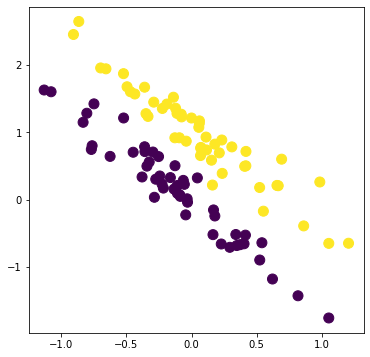

In [3]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100);

Accuracy: 0.87


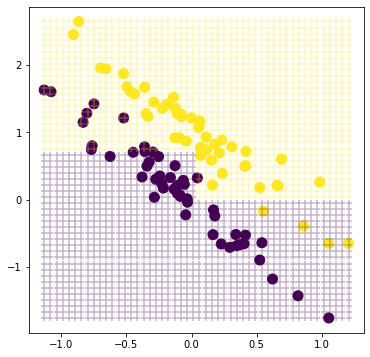

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# train a decision tree classifier
dt = DecisionTreeClassifier(max_leaf_nodes=4)
dt.fit(X,y)
print ("Accuracy:", accuracy_score(y_true=y, y_pred=dt.predict(X)) )

# compute the decition map
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)
Z = dt.predict(zz)

# plot data and decition map
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100)
ax.scatter(zz[:,0], zz[:,1], c=Z, marker='+', alpha=0.3);

## How can we improve the accuracy of a classifier ?

- Suppose we have 3 different classifiers, all with error rate 1/3.


- How can we exploit their predictions ?


- What is the probability that all of them are wrong ?
  - $(1/3)^3 = 1/27$


- What it the probability that the majority of them is wrong ?
  - $1/3\cdot1/3\cdot2/3 + 1/3\cdot2/3\cdot1/3 + 2/3\cdot1/3\cdot1/3 + 1/3\cdot1/3\cdot1/3 = $
  - $ 3 \left( 1/3\cdot1/3\cdot2/3 \right) + 1/3\cdot1/3\cdot1/3 = 7/27 \approx 26\%$


- So what ?
  - Each classifier has error rate 33% and accuracy 67%
  - Their combination has error rate 26% and accuracy 74% 
  

- And it improves with the number of classifiers


- An **Ensemble** provides greater accuracy even if its **weak learners** are not very accurate


- Note:
  - each classifier should do better than random
  - we are assuming classifiers are independent one another
     - Difficult given that they are trained on same/similar data


## What do we need to build an Ensemble ?

- Several different training datasets so to build different classifiers
  - Splitting may result in too little data
  - **Sampling** is a better solution


- A merging function to combine classifiers' predictions
  - **Majority** voting for classification
  - **Average** for regression

## Bagging Algorithm

- **Bootstrap aggregation** works by combining the prediction of $k$ models trained on a bootstrap sample of the given training dataset


- A bootstrap sample is obtained through **sampling with replacement**


- A bootstrap sample has the same size of the original dataset


- Bootstrap samples are all different (with high probability), and therefore the learned models are also different
  - an instance has ~63% probability of being part of the sample
    - each sample has a probability $1-(1-1/N)^N$, with $N$ being the size of the dataset, of being sampled
    - with a large $N$, this converges to $1-1/e\approx 0.632$
  
  
- **Bagging Algorithm**
  - For $i=1, ..., k$
    - Create a bootstrap sample $D_i$ of $D$
    - Build a model $M_i$ on $D_i$
  - Prediction for instance $x$ is the combination of all predictions $M_i(x)$
    - majority voting or average

Accuracy: 0.970


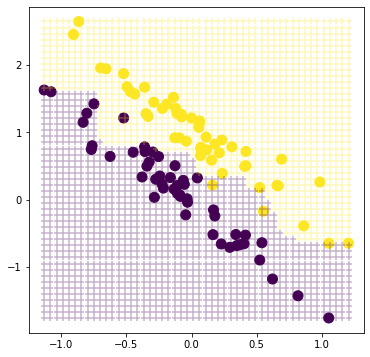

In [5]:
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier(max_leaf_nodes=4)
bagged_dt = BaggingClassifier(dt, n_estimators=100)

bagged_dt.fit(X,y)
print ("Accuracy: {:.3f}".format( accuracy_score(y_true=y, 
                                                 y_pred=bagged_dt.predict(X)) ) )

# compute the decition map
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)
Z = bagged_dt.predict(zz)

# plot data and decition map
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100)
ax.scatter(zz[:,0], zz[:,1], c=Z, marker='+', alpha=0.3);

- Try increasing the number of trees


- Accuracy hardly gets to 100%


- One of the reasons is that generated trees are too similar one another

## Boosting and AdaBoost

- Ideally we would like to fix those instances for which our prediction was not correct


- AdaBoost/Boosting is an improvement over bagging


- Instances are sampled with larger probability if their prediction is wrong


- Predictions by the weak learners of the ensemble are weighted depending on their accuracy

### Sampling

Sampling is with replacement as for bagging.


Sampling is not uniform. The probability of selecting an instance $x_j$ at each step of the sampling process is given by its weight $w_j$.


Initially every instance $x_j$ has weight $w_j=1/N$, where $N$ is the size of the dataset.


### Instance weighting



After training a new model $M_i$ over a sample $D_i$, we measure its error rate on the initial dataset as:


$$
error(M_i) = \sum_{(x_j,y_j) \in D} w_k \cdot \mathbb{1}[M_i(x_j)\neq y_j]
$$

where $\mathbb{1}[condition]=1$ if $condition$ is true and 0 otherwise.


$error(M_i)$ is large when predictions are not correct for instances with large weights.

**Each learner is weighted according to its error/accuracy**.


The weight of $M_i$ is $\alpha_i$:
$$
\alpha_i = \log\frac{1-error(M_i)}{error(M_i)}
$$


 - The above is also called *logit* or *log-odds* and it maps a probability ($error(M_i)$) into a real number in $[-\infty,+\infty]$,
 - Large errors are mapped into large negative values, and viceversa.
 - Error equal to 0.5 is mapped to 0.0.


The prediction is given by the class with the *weighted* majority voting.


The error rate is used to **update the weights of the instances**.



If an instance $x_j\in D$ is **correctly** classified then its weight is updated as follows:


$$
w_j = w_j e^{-\alpha_i}
$$

If an instance $x_j\in D$ is **incorrectly** classified then its weight is updated as follows:


$$
w_j = w_j e^{\alpha_i}
$$


This decreases the weight of correctly classified instances and increases the weights of incorrectly classified instances. 


After this, weights are are normalized so as to sum up to 1:

$$
w_j = \frac{w_j}{\sum_k w_k}
$$


The new weights are used for the next sampling.


### Learners weighting



### AdaBoost

1. initialize the weight $w_j=1/n$ for each instance $x_j$
1. $E = \emptyset$
1. for $i=1$ to $k$:
1. $\quad$ get $D_i$ by sampling $D$ with replacement according weights $w_j$
1. $\quad$ train a model $M_i$ on $D_i$
1. $\quad$ compute $error(M_i)$ on $D$
1. $\quad$ if $error(M_i) > 0.5$ then go step 4
1. $\quad$ compute model's importance $\alpha_i$
1. $\quad$ update weights of instances in $D$
1. $\quad$ add $\alpha M_i$ to the final ensemble $E$
1. return $E$

Accuracy: 1.000


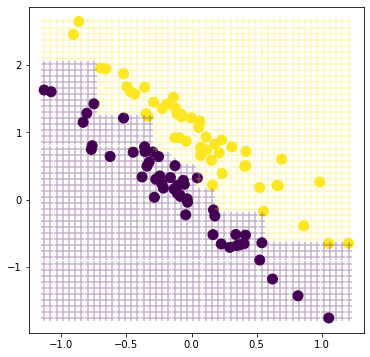

In [6]:
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_leaf_nodes=4)
adaboost = AdaBoostClassifier(dt, n_estimators=10)

adaboost.fit(X,y)
print ("Accuracy: {:.3f}".format( accuracy_score(y_true=y, 
                                                 y_pred=adaboost.predict(X)) ) )


# compute the decition map
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)
Z = adaboost.predict(zz)

# plot data and decision map
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100)
ax.scatter(zz[:,0], zz[:,1], c=Z, marker='+', alpha=0.3);

## Exercise: apply the regression versions of Bagging and Boosting to a regression dataset

## Bias-Variance Decomposition

The error of a classifier can be decomposed in:
- **Bias**$^2$
  - The error of the average prediction for an instance $x$
  - The goodness of the algorithm for the specific problem
    - Can you model non-linear relations with a linear model ?


- **Variance**:
  - The variance of predictions for the same $x$
  - The sensitivity of the learning algorithm to the specific training set
  
  
- **Irreducible Error/Noise**:
  - Errors in the dataset: wrong labels or wrong features
  - This cannot be removed


For regression with mean squared error, error it is exactly the sum of the above.

$$
Error(M) = Bias^2 + Variance + Noise
$$

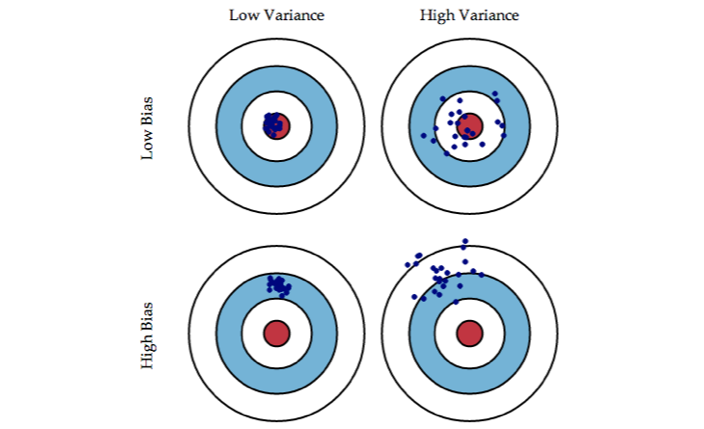

- With finite data, it can be approximated by generating several models from different boostrap samples.
  - see example: https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py
  

See also:
 - see: http://scott.fortmann-roe.com/docs/BiasVariance.html
  

**Question**: 
 - How is the bias variance of a decision tree classifier?
 - What if we change the number of leaves?

Sample vs. Global Accuracy: 0.970 - 0.910
Sample vs. Global Accuracy: 0.955 - 0.840
Sample vs. Global Accuracy: 0.985 - 0.920


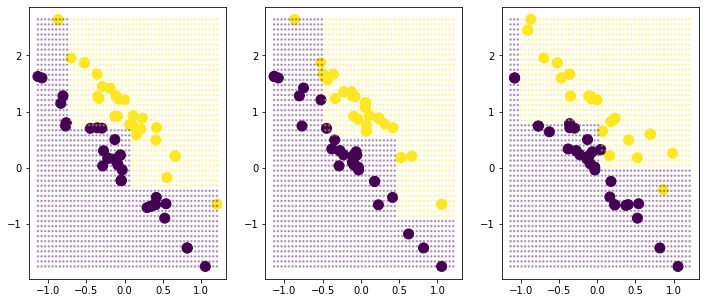

In [7]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# generate some random data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=[[0,0],[1,1]], 
                  cluster_std=.3, random_state=2)
transformation = [[1, -1], [-1, 2]]
X = np.dot(X, transformation)


N_TESTS = 3

# plot data and decition map
fig, ax = plt.subplots(1,N_TESTS, figsize=(12,5))

for i in range(N_TESTS):
    Xs, ys = resample(X,y, n_samples=int(0.66*len(y)) )

    # train a decision tree classifier
    dt = DecisionTreeClassifier(max_leaf_nodes=5) # change this!
    dt.fit(Xs,ys)
    print ("Sample vs. Global Accuracy: {:.3f} - {:.3f}".format( 
           accuracy_score(y_true=ys, y_pred=dt.predict(Xs)), 
           accuracy_score(y_true=y, y_pred=dt.predict(X)) ) )

    # compute the decition map
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
                   for yy in np.linspace(y_min, y_max, 50) ]
    zz = np.array(zz)
    Z = dt.predict(zz)

    ax[i].scatter(Xs[:,0], Xs[:,1], c=ys, s=100)
    ax[i].scatter(zz[:,0], zz[:,1], c=Z, marker='.', alpha=0.3, s=10)

#### - A fully grown tree has:
  - little bias, as it can fit any training input
  - large variance, as its prediction varies significantly across different inputs
  
- A small tree has:
  - large bias, as it does not fit well the training input
  - low variance, as its prediction does not vary significantly across different inputs

- **Bagging** reduces variance of a base classifier
  - as predictions are averaged, the classifier gains "stability"
  - by properties of variance, the variance of the mean of of $n$ independent random variables all with variance $\sigma^2$ equals to $\sigma^2/n$
  
- **Boosting** reduces bias of a base classifier
  - by retraining on the most difficult instances
  
  
- Bagging should be applied to models with low bias and high variance
- Boosting should be applied to models with high bias and low variance


## Over-fitting versus Under-fitting

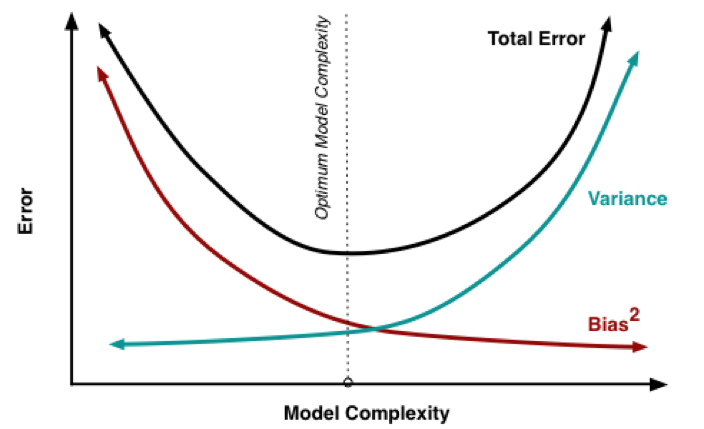

### Increasing the complexity of a decision tree, i.e., number of nodes.

In [8]:
# generate some ransom data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[0,0],[1,1]], 
                  cluster_std=.3, random_state=2)
transformation = [[1, -1], [-1, 2]]
X = np.dot(X, transformation)

Error/Bias/Variance at the last iteration: [0.02255   0.0051525 0.0173975]


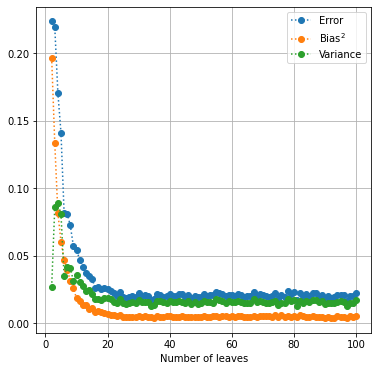

In [9]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

N_TESTS = 20

stats = np.array([])

n_leaves = range(2,101)

for l in n_leaves:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        # train a decision tree classifier
        dt = DecisionTreeClassifier(max_leaf_nodes=l)
        dt.fit(Xs,ys)
        
        y_pred  = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    # actual y vs. avg prediction
    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    # variance of predictions
    dt_variance = np.var(y_preds,axis=1)
    # MSE error (even if this is classification)
    dt_error    = (y_preds - y.reshape(-1,1))**2
    
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(n_leaves,stats[0,:], 'o:', label='Error')
ax.plot(n_leaves,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(n_leaves,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of leaves')
ax.grid()
ax.legend()

print ("Error/Bias/Variance at the last iteration:", stats[:,-1])

### Increasing the number of kneighbours of a k-NN classifier

Recall what happens when $k \rightarrow +\infty$.


In [ ]:
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier


N_TESTS = 20

stats = np.array([])

n_neighs = range(1,101)
for l in n_neighs:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        # train a decision knn classifier
        knn = KNeighborsClassifier(n_neighbors=l)
        knn.fit(Xs,ys)
        
        y_pred = knn.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2
    
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(n_neighs,stats[0,:], 'o:', label='Error')
ax.plot(n_neighs,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(n_neighs,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of kneighbours')
ax.grid()
ax.legend()

print ("Error/Bias/Variance at the last iteration:", stats[:,-1])

### Increasing the amount of data considered


In [ ]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier


N_TESTS = 20

stats = np.array([])

n_inst = range(2,101)
for n in n_inst:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=n)

        # train a decision tree classifier
        dt = DecisionTreeClassifier(max_leaf_nodes=20)
        dt.fit(Xs,ys)
        
        y_pred = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2
    
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(n_inst,stats[0,:], 'o:', label='Error')
ax.plot(n_inst,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(n_inst,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of instances')
ax.grid()
ax.legend()

print ("Error/Bias/Variance at the last iteration:", stats[:,-1])

## Using Bagging to reduce Variance

Vary the number of bagging rounds on a decision tree with 100 leaves

In [ ]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

N_TESTS = 20

stats = np.array([])

bags = range(1,21)

for l in bags:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        # train a decision tree classifier
        dt = DecisionTreeClassifier(max_leaf_nodes=100)
        bagged_dt = BaggingClassifier(dt, n_estimators=l)
        bagged_dt.fit(Xs,ys)
        
        y_pred = bagged_dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2
    
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(bags,stats[0,:], 'o:', label='Error')
ax.plot(bags,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(bags,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of Bagging rounds')
ax.grid()
ax.legend()

print ("Error/Bias/Variance at the last iteration:", stats[:,-1])

## Using Boosting to reduce Bias

Vary the number of bagging rounds on a decision tree with 2 leaves only

In [ ]:
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

N_TESTS = 20

stats = np.array([])

boosts = range(1,51)
for l in boosts:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        # train a decision tree classifier
        dt = DecisionTreeClassifier(max_leaf_nodes=2)
        adaboost = AdaBoostClassifier(dt, n_estimators=l)
        adaboost.fit(Xs,ys)
        
        y_pred = adaboost.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2
    
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(boosts,stats[0,:], 'o:', label='Error')
ax.plot(boosts,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(boosts,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of Boosting rounds')
ax.grid()
ax.legend()

print ("Error/Bias/Variance at the last iteration:", stats[:,-1])